In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def clean_data(filepath):
    """
    Loads and performs a full cleaning process on the ride-hailing dataset.

    Args:
        filepath (str): The path to the ncr_ride_bookings.csv file.

    Returns:
        pandas.DataFrame: A cleaned DataFrame focusing on completed rides.
    """
    # Load the dataset
    df = pd.read_csv(filepath)
    print("--- Data loaded successfully. Starting cleaning process... ---")

    # --- Step 1: Basic Cleaning ---
    df.columns = df.columns.str.strip()
    df['Booking ID'] = df['Booking ID'].str.replace('"', '')
    df['Customer ID'] = df['Customer ID'].str.replace('"', '')

    # --- Step 2: Datetime Conversion ---
    df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d-%m-%Y %H:%M:%S')
    df = df.drop(['Date', 'Time'], axis=1)

    # --- Step 3: Handle Missing Values ---
    completed_rides = df[df['Booking Status'] == 'Completed'].copy()
    print(f"Filtered for {len(completed_rides)} completed rides.")

    numerical_cols = ['Avg VTAT', 'Avg CTAT', 'Booking Value', 'Ride Distance', 'Driver Ratings', 'Customer Rating']
    for col in numerical_cols:
        median_value = completed_rides[col].median()
        completed_rides[col] = completed_rides[col].fillna(median_value)

    mode_value = completed_rides['Payment Method'].mode()[0]
    completed_rides['Payment Method'] = completed_rides['Payment Method'].fillna(mode_value)
    
    print("--- Cleaning process complete. ---")
    return completed_rides

In [3]:
def analyze_cancellation_reasons(df):
    """
    Analyzes and plots the reasons for cancellations by customers and drivers.
    This function should be run on the raw dataframe before filtering for completed rides.
    """
    print("\n--- Analyzing cancellation reasons... ---")
    fig, axes = plt.subplots(2, 1, figsize=(12, 14))
    fig.suptitle('Cancellation Reason Analysis', fontsize=16)

    # Customer Cancellation Reasons
    customer_reasons = df['Reason for cancelling by Customer'].dropna().value_counts()
    sns.barplot(ax=axes[0], y=customer_reasons.index, x=customer_reasons.values, palette='Reds_d')
    axes[0].set_title('Top Reasons for Cancellation by Customer')
    axes[0].set_xlabel('Number of Cancellations')
    axes[0].set_ylabel('Reason')

    # Driver Cancellation Reasons
    driver_reasons = df['Driver Cancellation Reason'].dropna().value_counts()
    sns.barplot(ax=axes[1], y=driver_reasons.index, x=driver_reasons.values, palette='Blues_d')
    axes[1].set_title('Top Reasons for Cancellation by Driver')
    axes[1].set_xlabel('Number of Cancellations')
    axes[1].set_ylabel('Reason')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [4]:
def analyze_demand_by_time(df):
    """Analyzes and plots ride demand by hour of day and day of week."""
    print("\n--- Analyzing demand by time... ---")
    fig, axes = plt.subplots(2, 1, figsize=(12, 12))
    fig.suptitle('Ride Demand Analysis', fontsize=16)

    sns.countplot(ax=axes[0], data=df, x=df['datetime'].dt.hour, palette='viridis')
    axes[0].set_title('Hourly Booking Demand')
    axes[0].set_xlabel('Hour of Day (0-23)')
    axes[0].set_ylabel('Number of Bookings')

    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    sns.countplot(ax=axes[1], data=df, x=df['datetime'].dt.day_name(), order=day_order, palette='plasma')
    axes[1].set_title('Daily Booking Demand')
    axes[1].set_xlabel('Day of the Week')
    axes[1].set_ylabel('Number of Bookings')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [5]:
def analyze_busiest_locations(df):
    """Analyzes and plots the top 10 busiest pickup locations."""
    print("\n--- Analyzing busiest pickup locations... ---")
    top_10_pickup = df['Pickup Location'].value_counts().nlargest(10)

    plt.figure(figsize=(12, 8))
    sns.barplot(y=top_10_pickup.index, x=top_10_pickup.values, palette='magma')
    plt.title('Top 10 Busiest Pickup Locations')
    plt.xlabel('Number of Bookings')
    plt.ylabel('Pickup Location')
    plt.tight_layout()
    plt.show()

In [6]:
def analyze_monthly_trends(df):
    """Analyzes and plots booking trends by month."""
    print("\n--- Analyzing monthly trends... ---")
    month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    
    plt.figure(figsize=(12, 6))
    sns.countplot(data=df, x=df['datetime'].dt.month_name(), order=month_order, palette='inferno')
    plt.title('Monthly Booking Trends')
    plt.xlabel('Month')
    plt.ylabel('Number of Bookings')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [7]:
def analyze_trip_duration(df):
    """Analyzes and plots trip duration by location and hour."""
    print("\n--- Analyzing average trip duration... ---")
    top_5_locations = df['Pickup Location'].value_counts().nlargest(5).index
    top_locations_df = df[df['Pickup Location'].isin(top_5_locations)].copy()
    
    top_locations_df['hour'] = top_locations_df['datetime'].dt.hour

    pivot_table = pd.pivot_table(top_locations_df, values='Avg CTAT',
                                 index='Pickup Location', columns='hour',
                                 aggfunc=np.mean)

    plt.figure(figsize=(18, 8))
    sns.heatmap(pivot_table, cmap='YlGnBu', annot=True, fmt=".1f", linewidths=.5)
    plt.title('Average Trip Duration (in Mins) by Pickup Location and Hour of Day')
    plt.xlabel('Hour of Day')
    plt.ylabel('Pickup Location')
    plt.tight_layout()
    plt.show()

In [8]:
def analyze_vehicle_and_payment(df):
    """Analyzes and plots vehicle type popularity and payment method distribution."""
    print("\n--- Analyzing vehicle types and payment methods... ---")
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    fig.suptitle('Vehicle and Payment Analysis', fontsize=16)

    # Vehicle Type Popularity
    sns.countplot(ax=axes[0], data=df, y='Vehicle Type', order=df['Vehicle Type'].value_counts().index, palette='crest')
    axes[0].set_title('Vehicle Type Popularity')
    axes[0].set_xlabel('Number of Bookings')
    axes[0].set_ylabel('Vehicle Type')

    # Payment Method Distribution
    payment_counts = df['Payment Method'].value_counts()
    axes[1].pie(payment_counts, labels=payment_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Set2'))
    axes[1].set_title('Payment Method Distribution')
    axes[1].set_ylabel('') # Hide the y-label for pie chart

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [9]:
def analyze_ratings_distribution(df):
    """Analyzes and plots the distribution of driver and customer ratings."""
    print("\n--- Analyzing ratings distributions... ---")
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle('Ratings Distribution Analysis', fontsize=16)

    # Driver Ratings
    sns.histplot(ax=axes[0], data=df, x='Driver Ratings', bins=20, kde=True, color='skyblue')
    axes[0].set_title('Driver Ratings Distribution')
    axes[0].set_xlabel('Rating')
    
    # Customer Ratings
    sns.histplot(ax=axes[1], data=df, x='Customer Rating', bins=20, kde=True, color='salmon')
    axes[1].set_title('Customer Ratings Distribution')
    axes[1].set_xlabel('Rating')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [14]:
def analyze_distance_vs_value(df):
    """Analyzes and plots the relationship between ride distance and booking value."""
    print("\n--- Analyzing ride distance vs. booking value... ---")
    plt.figure(figsize=(10, 6))
    # Use a sample to avoid overplotting
    sample_df = df.sample(n=2000, random_state=42)
    # Use regplot to add a regression line to the scatter plot
    sns.regplot(data=sample_df, x='Ride Distance', y='Booking Value',
                scatter_kws={'alpha':0.4}, line_kws={'color': 'red'})
    plt.title('Ride Distance (km) vs. Booking Value with Trend Line')
    plt.xlabel('Ride Distance (km)')
    plt.ylabel('Booking Value')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


--- Analyzing cancellation reasons... ---


C:\Users\wasel\AppData\Local\Temp\ipykernel_14340\693419115.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[0], y=customer_reasons.index, x=customer_reasons.values, palette='Reds_d')
C:\Users\wasel\AppData\Local\Temp\ipykernel_14340\693419115.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[1], y=driver_reasons.index, x=driver_reasons.values, palette='Blues_d')


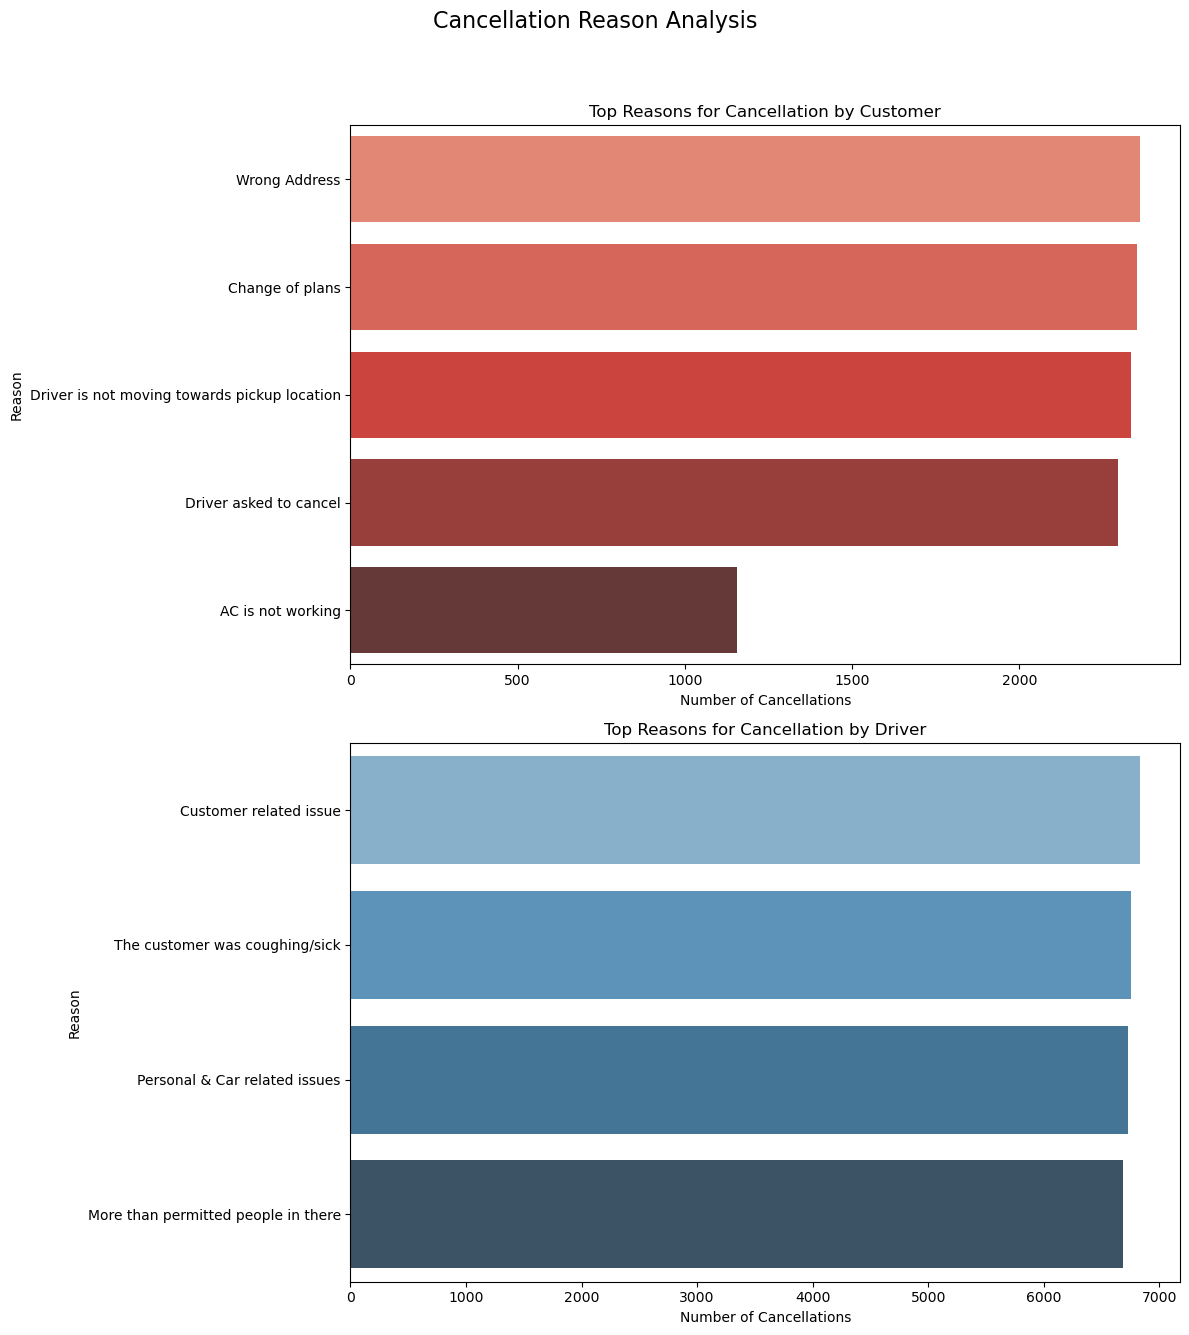

--- Data loaded successfully. Starting cleaning process... ---
Filtered for 93000 completed rides.
--- Cleaning process complete. ---

--- Analyzing demand by time... ---


C:\Users\wasel\AppData\Local\Temp\ipykernel_14340\571526065.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=axes[0], data=df, x=df['datetime'].dt.hour, palette='viridis')
C:\Users\wasel\AppData\Local\Temp\ipykernel_14340\571526065.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=axes[1], data=df, x=df['datetime'].dt.day_name(), order=day_order, palette='plasma')


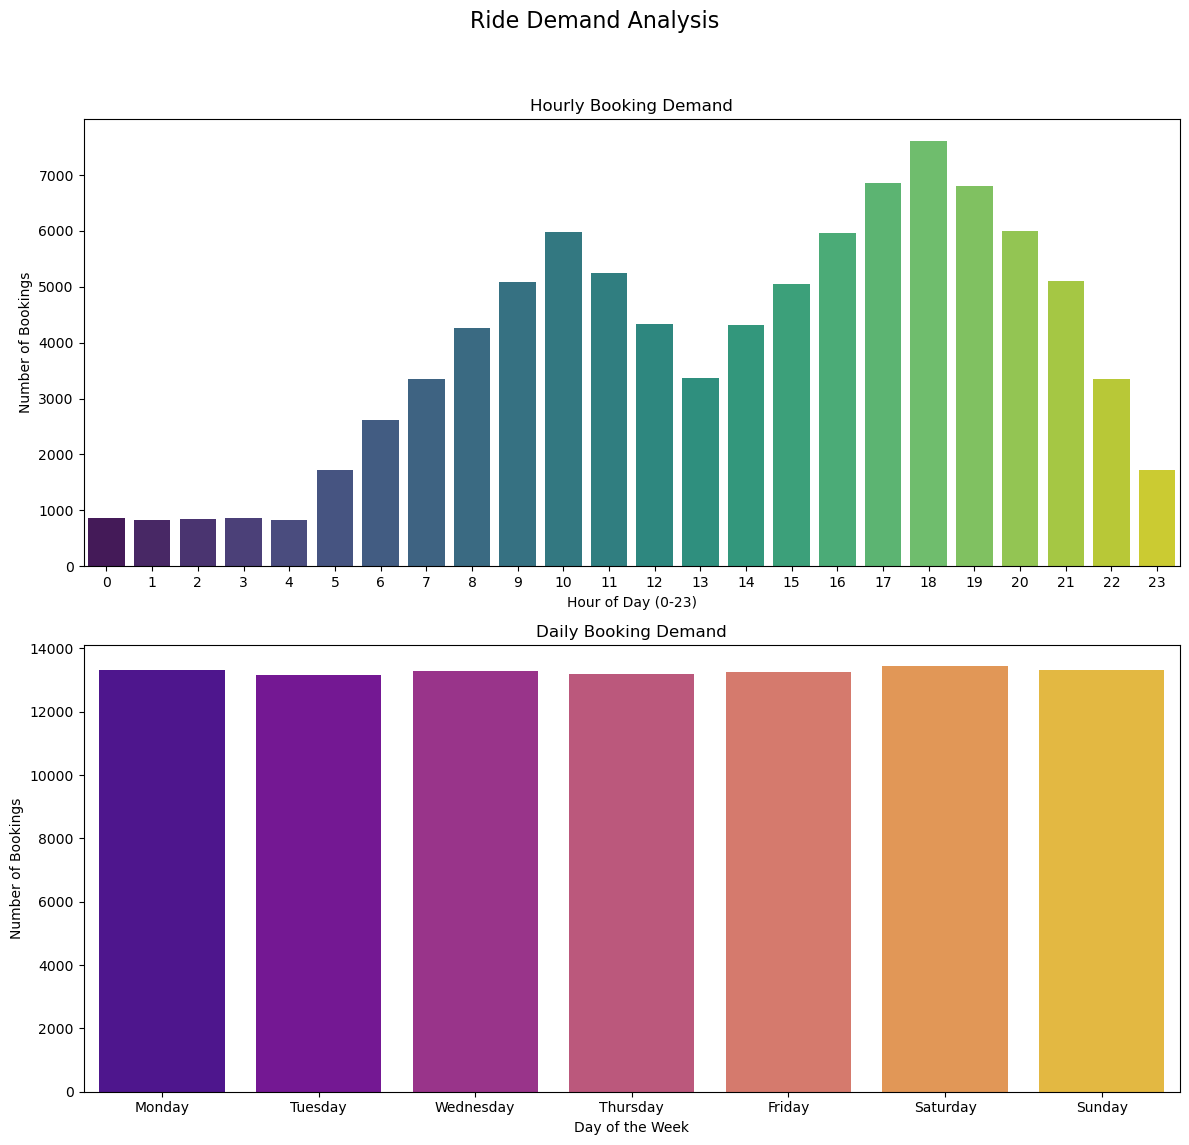


--- Analyzing busiest pickup locations... ---


C:\Users\wasel\AppData\Local\Temp\ipykernel_14340\871201253.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_10_pickup.index, x=top_10_pickup.values, palette='magma')


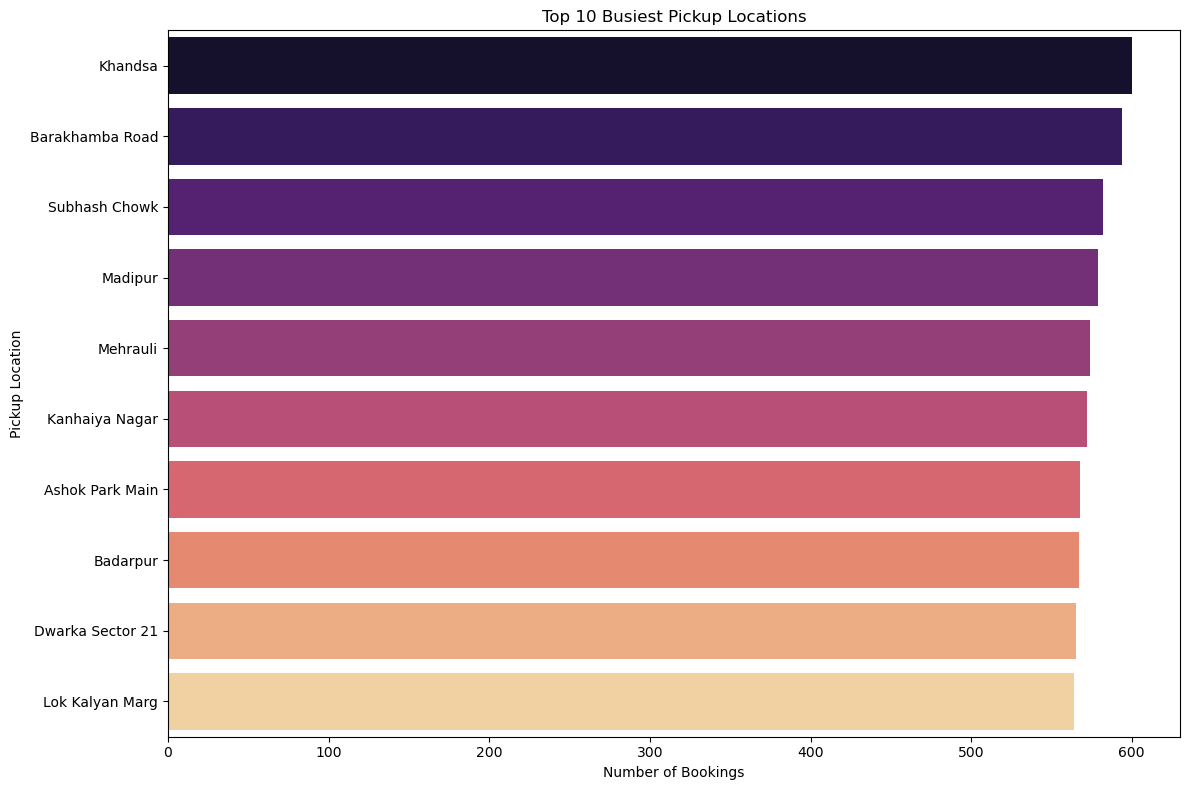


--- Analyzing monthly trends... ---


C:\Users\wasel\AppData\Local\Temp\ipykernel_14340\1232813976.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=df['datetime'].dt.month_name(), order=month_order, palette='inferno')


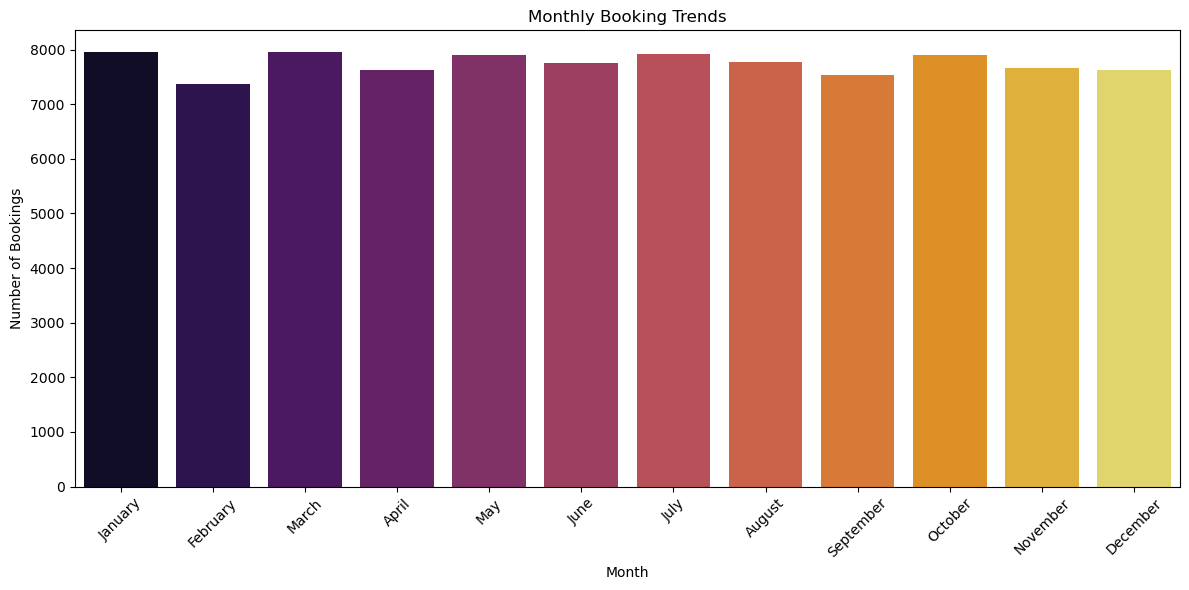


--- Analyzing average trip duration... ---


C:\Users\wasel\AppData\Local\Temp\ipykernel_14340\2343895662.py:9: FutureWarning: The provided callable <function mean at 0x0000020EA002F6A0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  pivot_table = pd.pivot_table(top_locations_df, values='Avg CTAT',


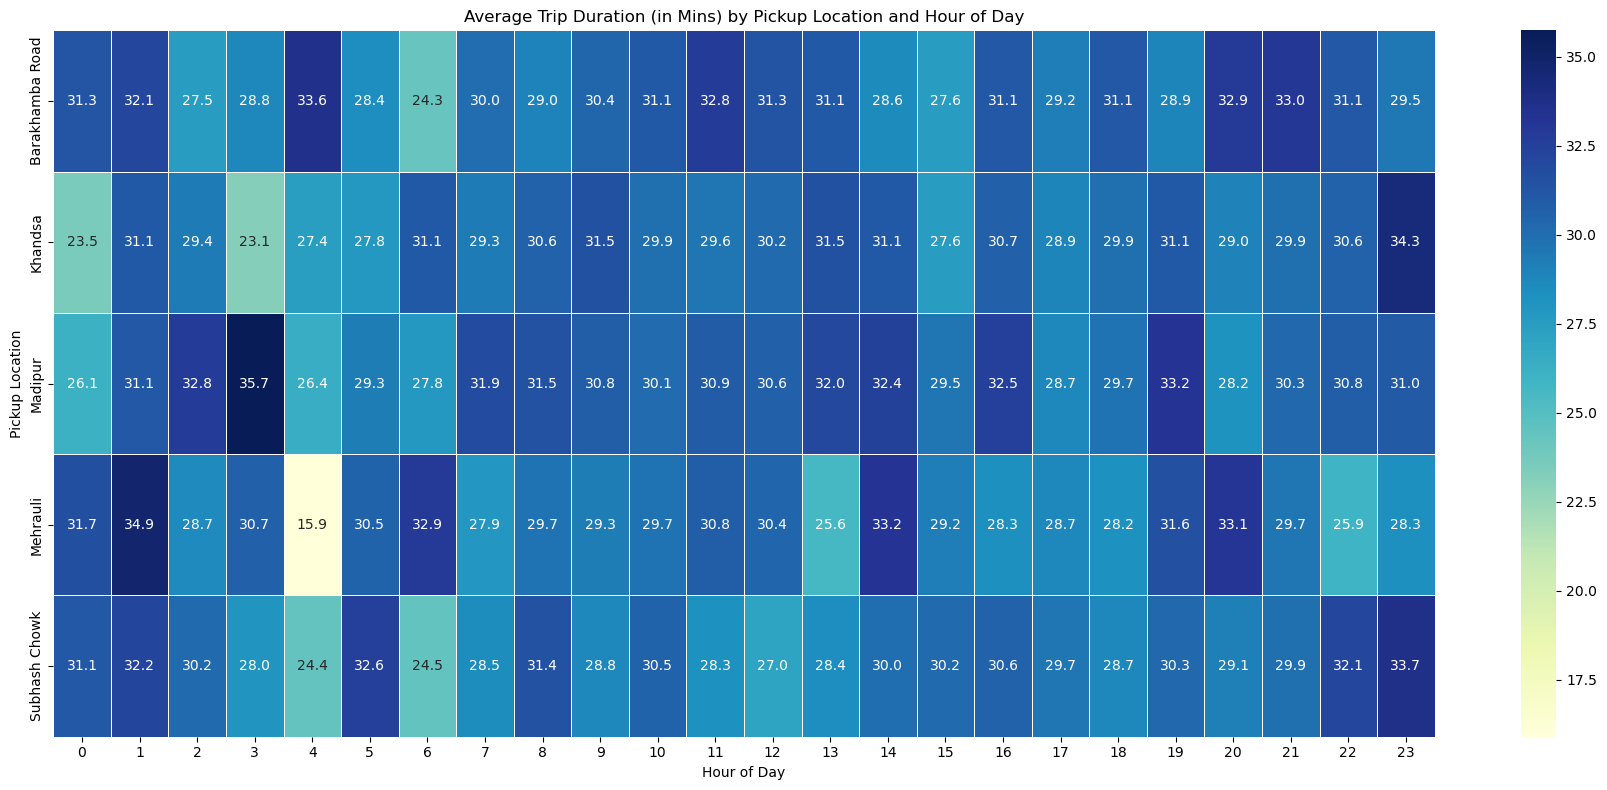


--- Analyzing vehicle types and payment methods... ---


C:\Users\wasel\AppData\Local\Temp\ipykernel_14340\1644729081.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=axes[0], data=df, y='Vehicle Type', order=df['Vehicle Type'].value_counts().index, palette='crest')


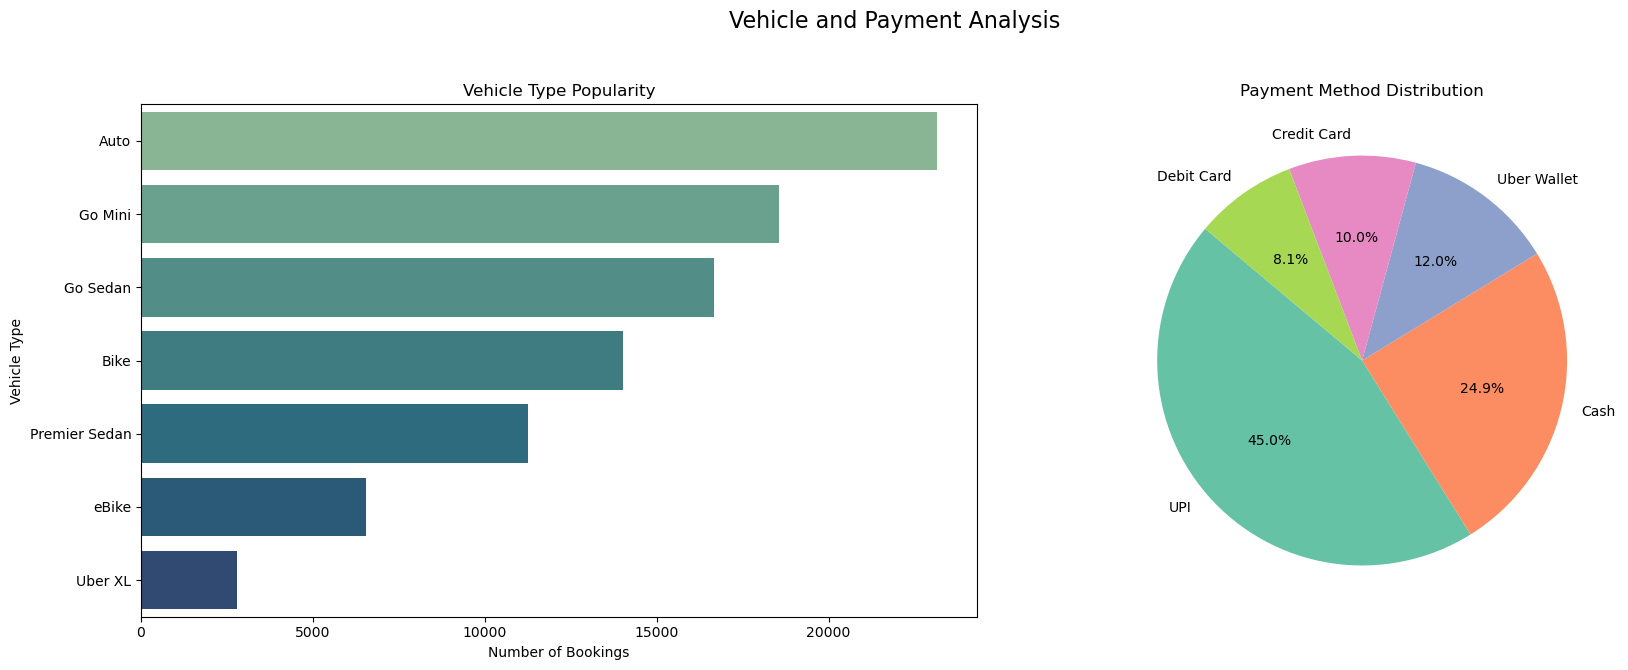


--- Analyzing ratings distributions... ---


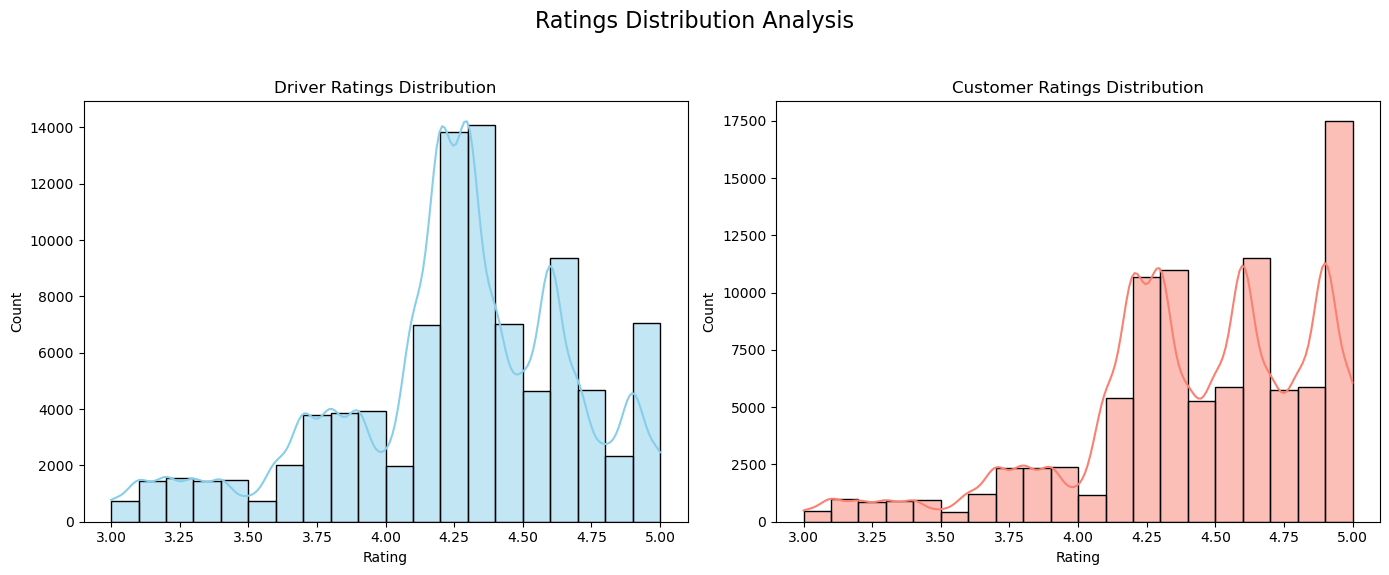


--- Analyzing ride distance vs. booking value... ---


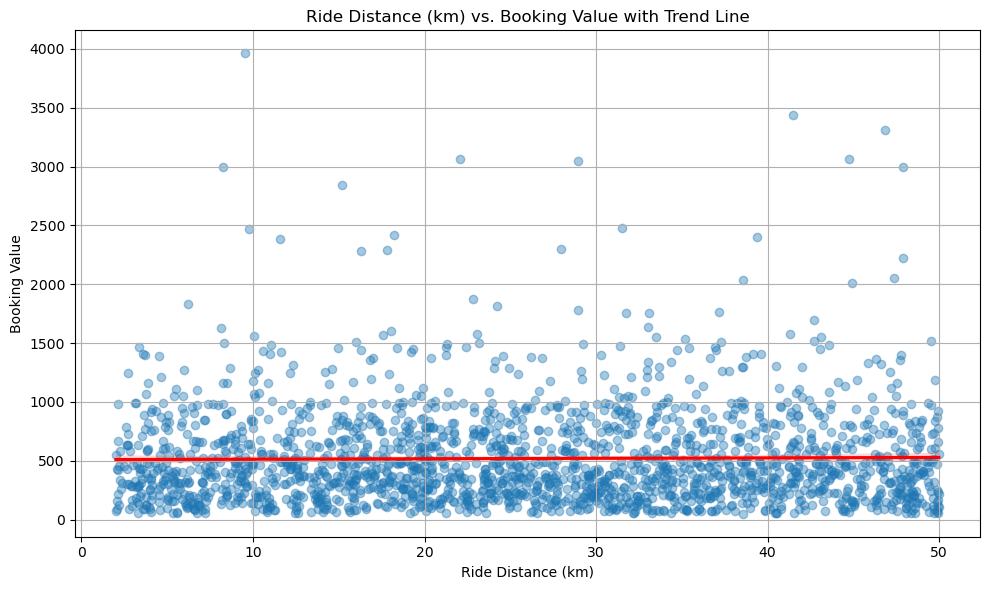


--- Analysis complete. All plots have been displayed. ---


In [13]:
if __name__ == "__main__":
    # Define the file path for the dataset
    FILEPATH = 'ncr_ride_bookings.csv'
    
    # --- New Step: Load raw data once for cancellation analysis ---
    raw_df = pd.read_csv(FILEPATH)
    analyze_cancellation_reasons(raw_df)

    # Run the cleaning and analysis for completed rides
    cleaned_df = clean_data(FILEPATH)
    
    # Generate all other visualizations on the cleaned data
    analyze_demand_by_time(cleaned_df)
    analyze_busiest_locations(cleaned_df)
    analyze_monthly_trends(cleaned_df)
    analyze_trip_duration(cleaned_df)
    analyze_vehicle_and_payment(cleaned_df)
    analyze_ratings_distribution(cleaned_df)
    analyze_distance_vs_value(cleaned_df)
    
    print("\n--- Analysis complete. All plots have been displayed. ---")